In [5]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

weather = pd.read_sql_query('select * from weatherinszeged',con=engine)

engine.dispose()

postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

house = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

print(weather.shape)
print(house.shape)

(96453, 12)
(1460, 81)


In [6]:
weather = weather[weather.pressure != 0]

# Part 1 - Weather model

In [21]:
y = weather['temperature']
X = weather[['humidity', 'windspeed', 'windbearing', 'pressure']]
X = sm.add_constant(X)

results = sm.OLS(y,X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                 2.668e+04
Date:                Mon, 18 Nov 2019   Prob (F-statistic):               0.00
Time:                        23:09:24   Log-Likelihood:            -3.1395e+05
No. Observations:               95165   AIC:                         6.279e+05
Df Residuals:                   95160   BIC:                         6.280e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         463.3827      2.890    160.341      0.000     457.718     469.047
humidity      -32.7468      0.112   -293.654      0.000     -32.965     -32.528
windspeed      -0.3178      0.003    -96.871      0.000      -0.324      -0.311
windbearing     0.0025      0.000     12.679      0.000       0.002       0.003
pressure       -0.4174      0.003   -147.569      0.000      -0.423      -0.412
==============================================================================
Omnibus:                     3441.751   Durbin-Watson:                   0.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3960.090
Skew:                          -0.450   Prob(JB):                         0.00
Kurtosis:                       3.436   Cond. No.                     1.41e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Condition 1: Linearity of Model in its Coefficients

In [ ]:
Assumed by estimation method.

### Condition 2: Error term should be 0 on average

In [8]:
predict = results.predict(X)
errors = y - predict
np.mean(errors)

-3.433492686416361e-12

### Condition 3: Homoscedasticity

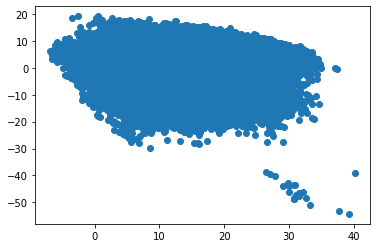

In [9]:
plt.scatter(predict, errors)
plt.show()

In [10]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predict, errors)
lev_stats = levene(predict, errors)

print(bart_stats)
print(lev_stats)

BartlettResult(statistic=313.45767618793496, pvalue=3.854840835961656e-70)
LeveneResult(statistic=235.66275179688216, pvalue=3.7357507560786247e-53)


Based on both the tests, we can safely reject homoskedasticity. This causes more of an issue with our standard errors than our estimates. Our standard errors/p-values will signal artificially high confidence as a result of this assumption being violated.

### Condition 4: Low Multicollinearity

In [15]:
X.iloc[:,1:].corr()

,humidity,windspeed,windbearing,pressure
humidity,1.000000,-0.224282,0.001598,0.039257
windspeed,-0.224282,1.000000,0.101633,-0.253700
windbearing,0.001598,0.101633,1.000000,-0.078687
pressure,0.039257,-0.253700,-0.078687,1.000000


The largest correlation (magnitude) is -.254 between windspeed and pressure. Windspeed and humidity is close at .224. I don't think this is high enough to cause an issue.

### Condition 5: Error terms are uncorrelated with each other

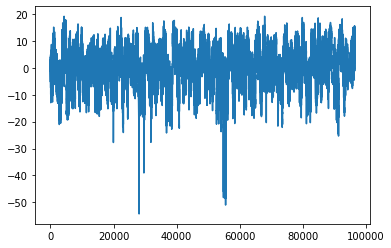

In [12]:
plt.plot(errors)
plt.show()

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


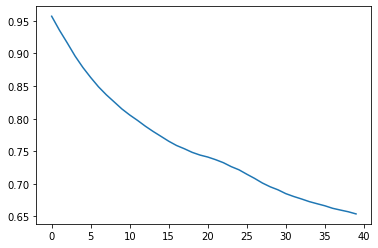

In [13]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

The autocorrelation is between .65 and .95, which is fairly high. So our model violates the autocorrelation assumption. There might be an important variable we are leaving out. Alternatively, our model may be better specified as a time series model, since temperature from day-to-day will be highly correlated.

### Condition 6: Features shouldn't be correlated with errors

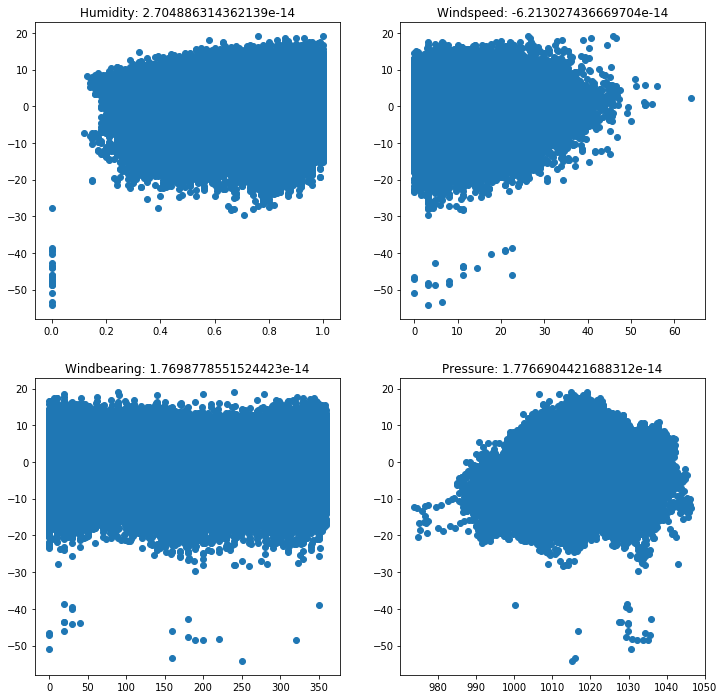

In [14]:
plt.figure(figsize=(12,12))

for c in range(1,X.shape[1]):
    '''if c==4:
        corr = np.corrcoef(X['pressure'][X.pressure != 0], errors[X.pressure != 0])
        plt.subplot(2,2,c)
        plt.scatter(X['pressure'][X.pressure != 0], errors[X.pressure != 0])
        plt.title('{}: {}'.format(X.columns[c].title(), corr[0,1]))'''       

    corr = np.corrcoef(X.iloc[:,c], errors)
    plt.subplot(2,2,c)
    plt.scatter(X.iloc[:,c], errors)
    plt.title('{}: {}'.format(X.columns[c].title(), corr[0,1]))


plt.show()

Features are not correlated with errors.

### Bonus condition: Normality of error terms

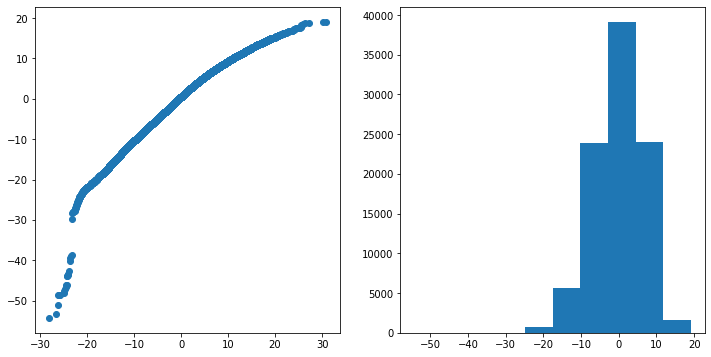

In [16]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors))

plt.subplot(1,2,2)
plt.hist(errors)

plt.show()

In [17]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 3960.0902389322846 and p value is 0.0
Normality test statistics is 3441.751245474618 and p value is 0.0


The error terms are not normally distributed. Again, our p-values will be off as a result.

# Part 2 - Housing model

In [22]:
y = house['saleprice']

X = house[['grlivarea', 'totalbsmtsf', 'fullbath', 'halfbath', 'overallqual', 'overallcond', 'yearbuilt', 'garagearea']]
X = sm.add_constant(X)

results = sm.OLS(y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     621.3
Date:                Mon, 18 Nov 2019   Prob (F-statistic):               0.00
Time:                        23:10:06   Log-Likelihood:                -17458.
No. Observations:                1460   AIC:                         3.493e+04
Df Residuals:                    1451   BIC:                         3.498e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.078e+06   1.04e+05    -10.322      0.000   -1.28e+06   -8.73e+05
grlivarea      56.7268      3.607     15.727      0.000      49.651      63.802
totalbsmtsf    27.7002      3.157      8.773      0.000      21.507      33.894
fullbath    -4205.0317   2830.361     -1.486      0.138   -9757.068    1347.005
halfbath    -2034.5941   2580.532     -0.788      0.431   -7096.565    3027.377
overallqual  1.947e+04   1161.885     16.761      0.000    1.72e+04    2.18e+04
overallcond  6557.8129    986.728      6.646      0.000    4622.247    8493.379
yearbuilt     494.5793     53.807      9.192      0.000     389.031     600.128
garagearea     44.6874      6.115      7.308      0.000      32.692      56.683
==============================================================================
Omnibus:                      569.028   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            83414.289
Skew:                          -0.722   Prob(JB):                         0.00
Kurtosis:                      40.002   Cond. No.                     2.93e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.93e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Condition 1: Linearity of Model in its Coefficients

### Condition 2: Average of errors should be 0

In [23]:
predict = results.predict(X)
errors = y - predict
np.mean(errors)

-8.187744740958083e-10

### Condition 3: Homoskedasticity

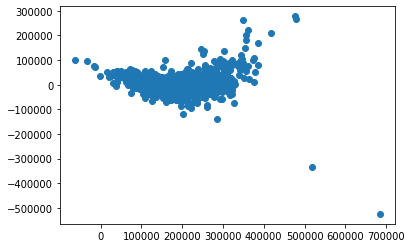

In [24]:
plt.scatter(predict, errors)
plt.show()

In [25]:
bart_stats = bartlett(predict, errors)
lev_stats = levene(predict, errors)

print(bart_stats)
print(lev_stats)

BartlettResult(statistic=521.0656566787916, pvalue=2.4813876821890605e-115)
LeveneResult(statistic=502.5264405249638, pvalue=7.994395685302524e-103)


In [ ]:
We can safely reject homoskedasticity. This will lead our p-values to be overconfident.

### Condition 4: Low multicollinearity

In [28]:
X.iloc[:,1:].corr()

,grlivarea,totalbsmtsf,fullbath,halfbath,overallqual,overallcond,yearbuilt,garagearea
grlivarea,1.000000,0.454868,0.630012,0.415772,0.593007,-0.079686,0.199010,0.468997
totalbsmtsf,0.454868,1.000000,0.323722,-0.048804,0.537808,-0.171098,0.391452,0.486665
fullbath,0.630012,0.323722,1.000000,0.136381,0.550600,-0.194149,0.468271,0.405656
halfbath,0.415772,-0.048804,0.136381,1.000000,0.273458,-0.060769,0.242656,0.163549
overallqual,0.593007,0.537808,0.550600,0.273458,1.000000,-0.091932,0.572323,0.562022
overallcond,-0.079686,-0.171098,-0.194149,-0.060769,-0.091932,1.000000,-0.375983,-0.151521
yearbuilt,0.199010,0.391452,0.468271,0.242656,0.572323,-0.375983,1.000000,0.478954
garagearea,0.468997,0.486665,0.405656,0.163549,0.562022,-0.151521,0.478954,1.000000


A lot of our features are fairly highly correlated. This shouldn't drastically affect prediction accuracy, but our point estimates will be suspect.

### Condition 5: Error terms are uncorrelated with each other

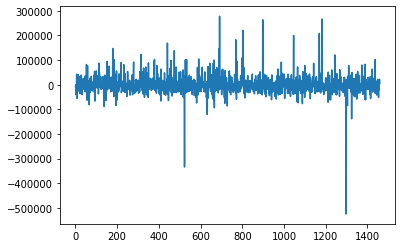

In [29]:
plt.plot(errors)
plt.show()

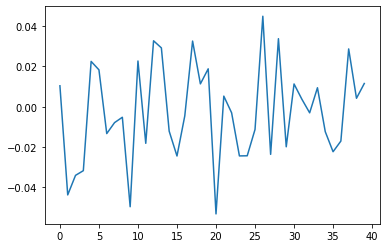

In [30]:
acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

Autocorrelation is low, so it looks like this assumption is satisfied.

### Condition 6: Features shouldn't be correlated with errors

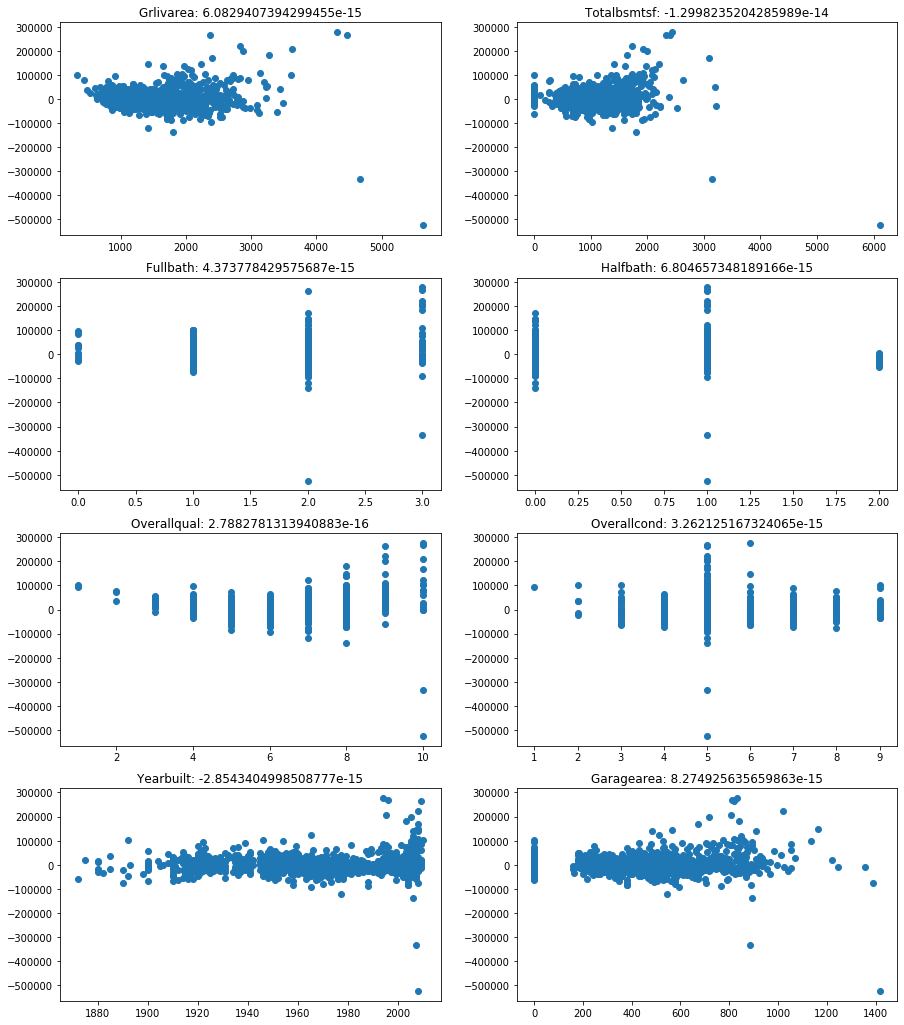

In [32]:
plt.figure(figsize=(15,18))

for c in range(1,X.shape[1]):
    corr = np.corrcoef(X.iloc[:,c], errors)
    plt.subplot(4,2,c)
    plt.scatter(X.iloc[:,c], errors)
    plt.title('{}: {}'.format(X.columns[c].title(), corr[0,1]))


plt.show()

### Bonus: Normality of error terms

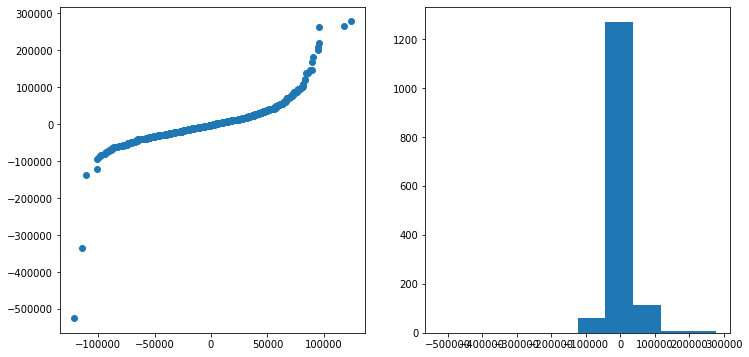

In [33]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors))

plt.subplot(1,2,2)
plt.hist(errors)

plt.show()

In [34]:
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 83414.2891556967 and p value is 0.0
Normality test statistics is 569.0278768054412 and p value is 2.7363177467936117e-124


Our error terms are not normally distributed. Our p-values will be inaccurate as a result.

In [31]:
X.shape

(1460, 9)